## **Twitter Sentiment Analysis**

In [1]:
import pandas as pd
import tensorflow as tf
import re
import os
import matplotlib.pyplot as plt
import numpy as np

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,Bidirectional
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print(tf.__version__)
!pip show distutils

2.17.0


### **Dataset Preview**

In [3]:
df_train = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_training.csv',header = None)

#berikan nama pada tiap header column
df_train.columns = ['tweet_id','product','sentiment','text']

df_train

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\INTEL\AppData\Local\Temp\ipykernel_17416\2706847385.py:1: SyntaxWarning: invalid escape sequence '\M'
  df_train = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_training.csv',header = None)


,tweet_id,product,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [4]:
df_test = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_validation.csv')

df_test.columns = ['tweet_id','product','sentiment','text']

df_test

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\INTEL\AppData\Local\Temp\ipykernel_17416\2026914374.py:1: SyntaxWarning: invalid escape sequence '\M'
  df_test = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_validation.csv')


,tweet_id,product,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [5]:
#Cek data kosong
print(df_train.info())
print('-----------------------')
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   product    74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   999 non-null    int64 
 1   product    999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB
None


In [6]:
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

In [7]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   product    74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       74682 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   999 non-null    int64 
 1   product    999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB
None


In [8]:
#cek apakah ada data kosong pada tiap row
print(df_train.isna().sum())
print(df_test.isna().sum())


tweet_id     0
product      0
sentiment    0
text         0
dtype: int64
tweet_id     0
product      0
sentiment    0
text         0
dtype: int64


In [9]:
#cek distribusi total produk berdasarkan komentar
product_counts = df_train['product'].value_counts()
print(product_counts)

product
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)       

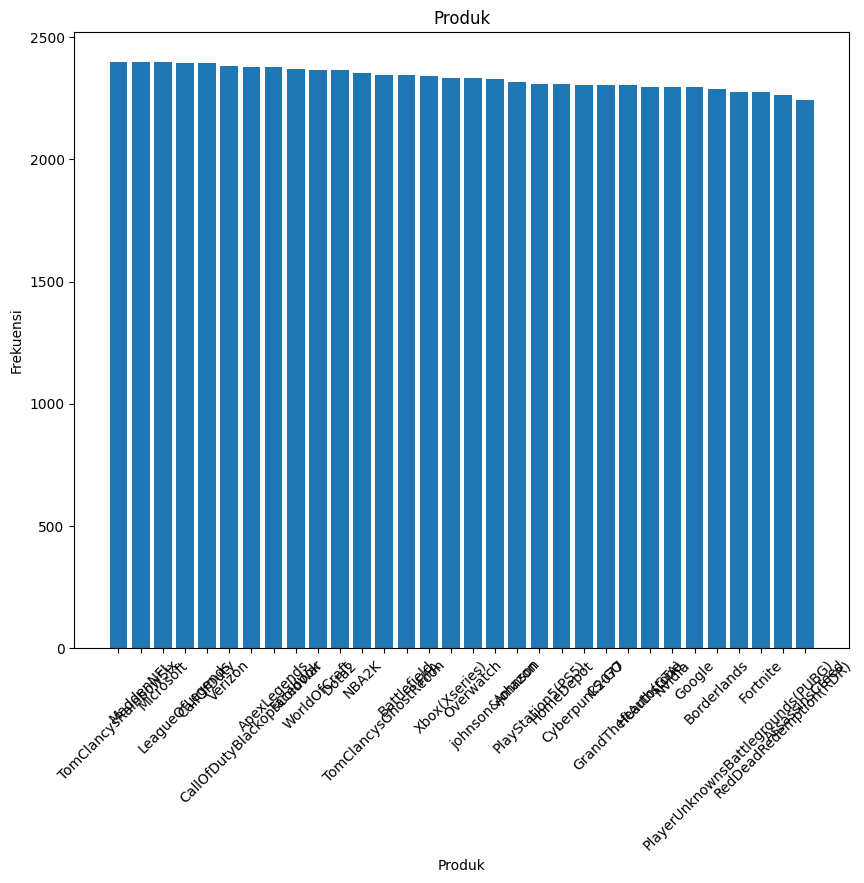

In [10]:
#Buat visualisasi
plt.figure(figsize=(10,8))
plt.bar(product_counts.index, product_counts.values)
plt.title("Produk")
plt.xlabel("Produk")
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()

## **Data Preprocessing**

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [12]:
from nltk.stem import WordNetLemmatizer

In [13]:
#Definisikan WordnetLemmatizer
lm = WordNetLemmatizer()

def preprocess_text(data):
    #definisikan array
    corpus = []

    stop_words = set(stopwords.words('english'))

    #iterasi tiap kata, potong, dan hilangkan kata2 yang mengandung unsur website
    for i in range(len(data)):
    #pertahankan kata2, hilangkan karakter, emot, dan unsur2 yang mengandung URL
        tweet = re.sub('[^a-zA-z]',' ',data[i])
    #kecilkan huruf
        tweet = tweet.lower()
    #split semua kalimat menjadi kata
        tweet = tweet.split()
    #stemming
        tweet = [lm.lemmatize(word) for word in tweet if not word in stop_words]
    #gabungkan kembali kata-katanya
        tweet = ' '.join(tweet)
    #kumpulkan ke dalam tweet
        corpus.append(tweet)

    return corpus

In [14]:
X_TRAIN = preprocess_text(df_train['text'])

X_TRAIN

['im getting borderland murder',
 'coming border kill',
 'im getting borderland kill',
 'im coming borderland murder',
 'im getting borderland murder',
 'im getting borderland murder',
 'spent hour making something fun know huge borderland fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent couple hour something fun know huge borderland fan maya one favorite character decided make wallpaper pc original picture compared creation made fun pic twitter com mlsi wf jg',
 'spent hour something fun know huge borderland fan maya one favorite character',
 'spent hour making something fun know huge rhandlerr fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent hour making something fun know huge rhandlerr fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg

Lakukan hal yang sama untuk data uji

In [15]:
X_TEST = preprocess_text(df_test['text'])

X_TEST

['bbc news amazon bos jeff bezos reject claim company acted like drug dealer bbc co uk news av busine',
 'microsoft pay word function poorly samsungus chromebook',
 'csgo matchmaking full closet hacking truly awful game',
 'president slapping american face really commit unlawful act acquittal discover google vanityfair com news',
 'hi eahelp madeleine mccann cellar past year little sneaky thing escaped whilst loading fifa point took card use paypal account working help resolve please',
 'thank eamaddennfl new te austin hooper orange brown brown austinhooper pic twitter com grg xzfkon',
 'rocket league sea thief rainbow six siege love playing three stream best stream twitch rocketleague seaofthieves rainbowsixsiege follow',
 'as still knee deep assassin creed odyssey way anytime soon lmao',
 'fix jesus please fix world going playstation askplaystation playstationsup treyarch callofduty negative silver wolf error code pic twitter com ziryhrf q',
 'professional dota scene fucking explodin

### **Preprocessing 1: Bag of Words**

Akan digunakan teknik "Bag of Words" untuk melakukan embedding pada data2 kalimat yang telah dibersihkan. Untuk menyematkan angka pada data kata-kata, digunakan CountVectorizer. CountVectorizer berguna untuk mengambil kata-kata unik tertentu berdasarkan jumlah frekuensi dan kemudian diberikan nilai angka unik untuk tiap kata. 

Tiap kata dalam kalimat disematkan angka-angka tersebut dan angka tersebut dikumpulkan menjadi 1 vektor.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
#Definisikan CountVectorizer, ambil semua kata unik yang paling sering muncul dari data
cv = CountVectorizer(max_features = 350, ngram_range = (1,3))

#Lakukan penyematan angka pada kata, dan pembuatan vektor pada kalimat.
X_TRAIN = cv.fit_transform(X_TRAIN).toarray()

#Setting untuk cetak matriks
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

X_TRAIN

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0

Lakukan hal yang sama untuk data test

In [18]:
X_TEST = cv.fit_transform(df_test['text']).toarray()

X_TEST

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0

In [19]:
cv.vocabulary_

{'news': 183,
 'amazon': 12,
 'company': 59,
 'like': 159,
 'co': 55,
 'microsoft': 174,
 'why': 325,
 'do': 73,
 'for': 92,
 'when': 320,
 'it': 143,
 'so': 244,
 'on': 198,
 'my': 178,
 'csgo': 64,
 'is': 141,
 'of': 190,
 'game': 99,
 'now': 188,
 'the': 263,
 'in': 137,
 'that': 262,
 'he': 122,
 'really': 232,
 'did': 71,
 'an': 13,
 'after': 4,
 'his': 128,
 'from': 95,
 'google': 111,
 'com': 56,
 '2020': 2,
 'in the': 138,
 've': 303,
 'had': 116,
 'years': 341,
 'and': 14,
 'thing': 276,
 'just': 149,
 'was': 314,
 'up': 299,
 'some': 246,
 'fifa': 87,
 'she': 242,
 'having': 121,
 'to': 283,
 'but': 43,
 'can': 50,
 'you': 342,
 'help': 124,
 'me': 173,
 'please': 222,
 'for the': 93,
 'and the': 16,
 'thank': 259,
 'eamaddennfl': 80,
 'new': 182,
 'pic': 212,
 'twitter': 297,
 'thank you': 260,
 'pic twitter': 213,
 'twitter com': 298,
 'pic twitter com': 214,
 'league': 152,
 'or': 205,
 'love': 165,
 'playing': 220,
 'all': 6,
 'stream': 252,
 'which': 322,
 'best': 36,
 '

### **Label Encoding**

In [20]:
#Pertama-tama, lihat dulu ada berapa jumlah kelas data untuk target
df_train['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [21]:
#Ubah menjadi angka
Y_TRAIN = df_train['sentiment']
Y_TEST = df_test['sentiment']

#Ubah menjadi angka label
lb = LabelEncoder()
Y_TRAIN = lb.fit_transform(Y_TRAIN)
Y_TEST = lb.fit_transform(Y_TEST)


### **Deep Learning Model**


In [22]:
#Penyusunan model Deep Learning
custom_model = tf.keras.Sequential()
custom_model.add(Embedding(input_dim = X_TRAIN.shape[0], output_dim = 128, input_length = X_TRAIN.shape[1]))
custom_model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
custom_model.add(MaxPooling1D(pool_size = 2))
custom_model.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout=0.2)))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(16, activation='relu'))
custom_model.add(Dense(4, activation='softmax'))

#Compiling Model
custom_model.compile(optimizer = 'adam',
loss = 'sparse_categorical_crossentropy',
metrics = ['accuracy'])


c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
#Buat summary
model_summary = custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### **Model Training**

In [24]:
tf.keras.backend.clear_session()

In [25]:
#define earlystopping
from tensorflow.keras.callbacks import EarlyStopping

#Define earlystopping
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
earlystopping

#fit and train model
history = custom_model.fit(X_TRAIN, Y_TRAIN,
validation_data = (X_TEST, Y_TEST),
epochs = 30,
batch_size = 64,
callbacks = [earlystopping])

#scoring
score, acc = custom_model.evaluate(X_TEST, Y_TEST, verbose = 0)
print(f'Test Score: {score}')
print(f'Test Accuracy: {acc}')



Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 214s 180ms/step - accuracy: 0.3000 - loss: 1.3658 - val_accuracy: 0.3263 - val_loss: 1.3726
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 229s 196ms/step - accuracy: 0.3358 - loss: 1.3409 - val_accuracy: 0.2663 - val_loss: 1.3739
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 239s 205ms/step - accuracy: 0.3023 - loss: 1.3672 - val_accuracy: 0.2993 - val_loss: 1.3749
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 219s 188ms/step - accuracy: 0.3031 - loss: 1.3631 - val_accuracy: 0.2783 - val_loss: 1.4029
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 224s 192ms/step - accuracy: 0.3268 - loss: 1.3414 - val_accuracy: 0.2823 - val_loss: 1.4025
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 226s 194ms/step - accuracy: 0.3333 - loss: 1.3358 - val_accuracy: 0.2973 - val_loss: 1.4083
Test Score: 1.3725719451904297
Test Accuracy: 0.3263263404369354


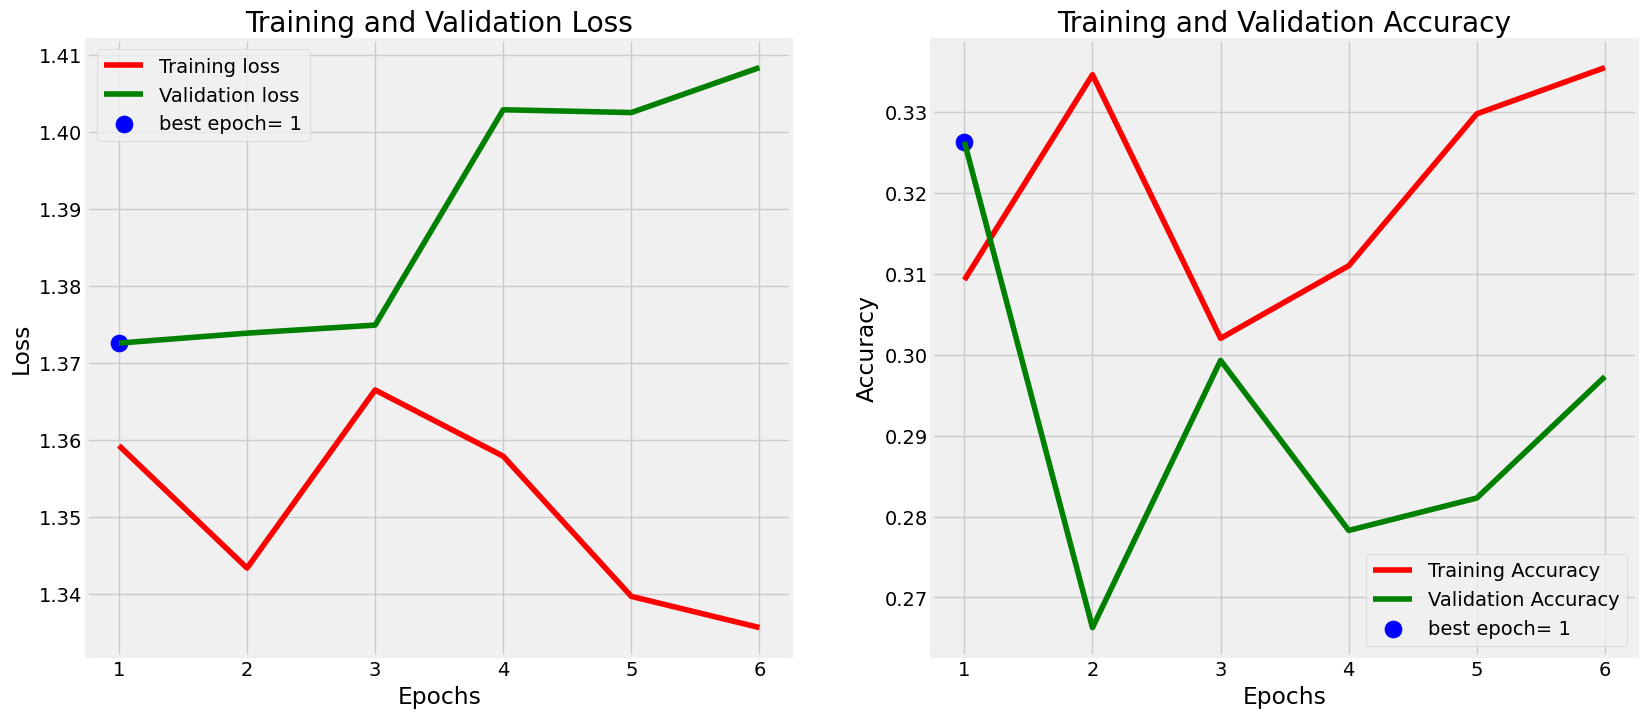

In [26]:
#Buat grafik utk keeping track
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [27]:
from sklearn.metrics import classification_report,f1_score

y_pred = np.argmax(custom_model.predict(X_TEST),axis = 1)
y_true = Y_TEST
accuracy_report = classification_report(y_pred,y_true)
print(accuracy_report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.60      0.30      0.40       524
           2       0.35      0.42      0.38       240
           3       0.24      0.29      0.26       235

    accuracy                           0.33       999
   macro avg       0.30      0.25      0.26       999
weighted avg       0.45      0.33      0.36       999



c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

### **Preprocessing 2 : TF-IDF Vectorizer**

In [28]:
#import sklearn.feature_extraction.text.TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
#Lakukan proses encoding data dengan TF-IDF Vectorizer dan juga pembuatan Ngrams
tf_idf = TfidfVectorizer(max_features = 100, binary = True, ngram_range = (1,3))

#Ulangi pembersihan data kalinat
X_TRAIN = preprocess_text(df_train['text'])
X_TEST = preprocess_text(df_test['text'])


#Lakukan pembuatan vektor TF-IDF
X_TRAIN = tf_idf.fit_transform(X_TRAIN).toarray()
X_TEST = tf_idf.fit_transform(X_TEST).toarray()

X_TRAIN

array([[0, 0, 0, 0, 0, 0, 0, 0.694, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.72, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0.694, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.72, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0.694, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.72, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0

In [30]:
#fit and train
custom_model.fit(X_TRAIN,Y_TRAIN,
validation_data = (X_TEST, Y_TEST),
epochs = 30,
batch_size = 64,
callbacks = [earlystopping])

#scoring
score, acc = custom_model.evaluate(X_TEST, Y_TEST, verbose = 0)
print(f'Test Score: {score}')
print(f'Test Accuracy: {acc}')

Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 107s 90ms/step - accuracy: 0.3022 - loss: 1.3664 - val_accuracy: 0.2733 - val_loss: 1.3736
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 105s 90ms/step - accuracy: 0.3119 - loss: 1.3593 - val_accuracy: 0.2723 - val_loss: 1.3713
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 105s 90ms/step - accuracy: 0.3142 - loss: 1.3583 - val_accuracy: 0.2733 - val_loss: 1.3742
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 105s 90ms/step - accuracy: 0.3188 - loss: 1.3546 - val_accuracy: 0.2653 - val_loss: 1.3721
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 390s 334ms/step - accuracy: 0.3194 - loss: 1.3542 - val_accuracy: 0.2683 - val_loss: 1.3726
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy: 0.3196 - loss: 1.3535 - val_accuracy: 0.2673 - val_loss: 1.3752
Epoch 7/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy: 0.3217 - loss: 1.3510 - val_accuracy: 0.2733 - val_loss: 1.3713
Epoch 8/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy:

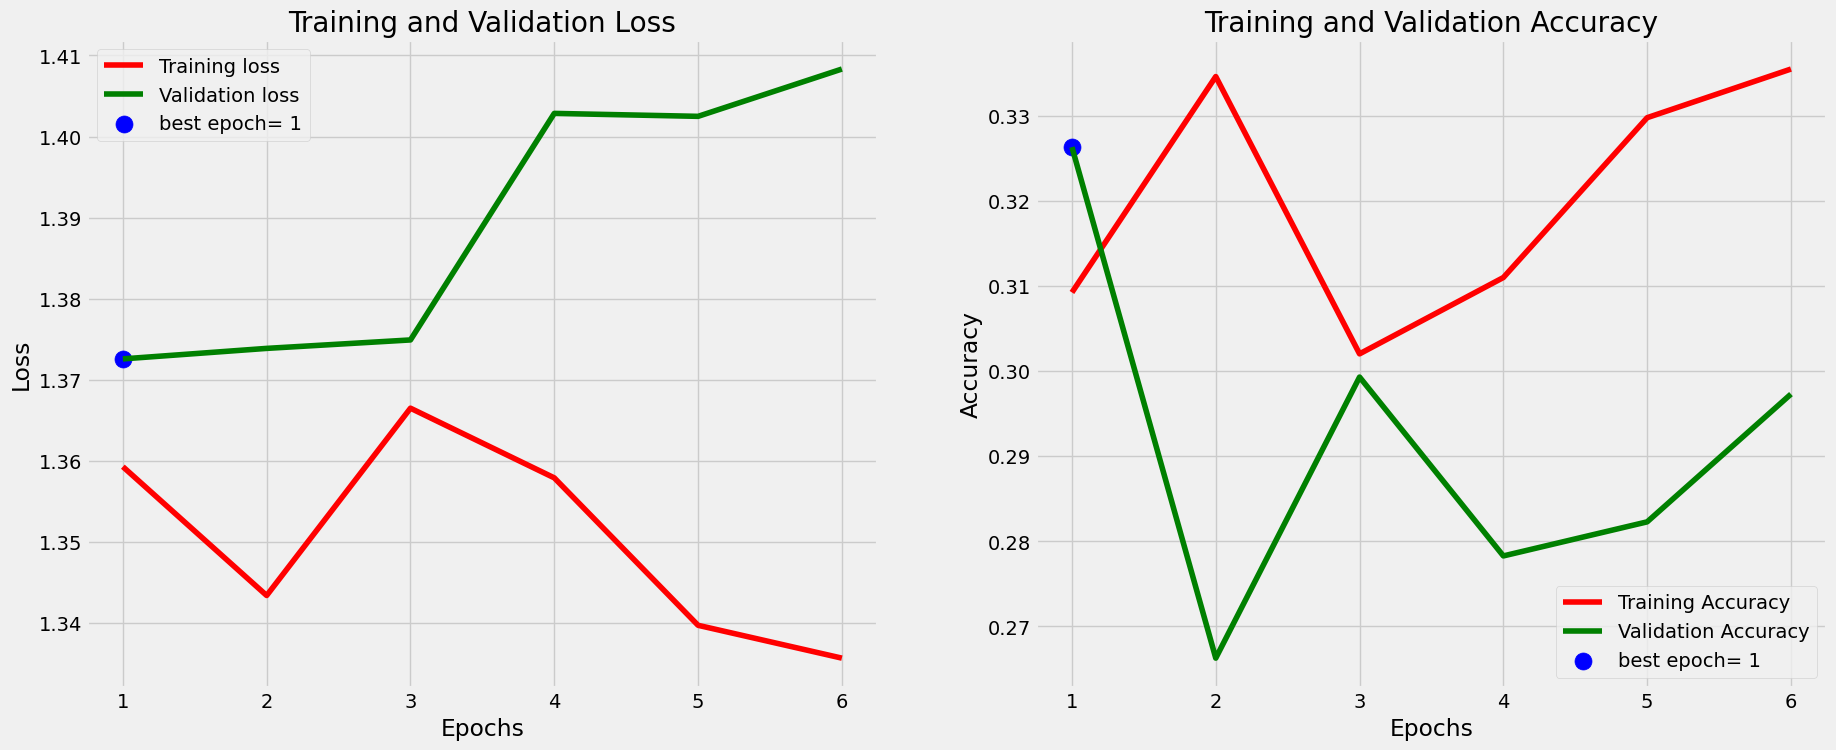

In [31]:
#visualize the accuracy and loss
#Buat grafik utk keeping track
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [32]:
y_pred = custom_model.predict(X_TEST)
y_pred = np.argmax(y_pred, axis = 1)
y_true = Y_TEST
#check f1 score

calculate_f1 = classification_report(y_true, y_pred)
print(calculate_f1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.27      0.94      0.42       266
           2       0.33      0.01      0.02       285
           3       0.39      0.07      0.12       277

    accuracy                           0.27       999
   macro avg       0.25      0.26      0.14       999
weighted avg       0.27      0.27      0.15       999



### **One - Hot Encoding**

In [33]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences

#define the vocab size
vocab_size = 500
#preprocess the data
X_TRAIN = [one_hot(word,vocab_size) for word in df_train['text']]
X_TEST = [one_hot(word,vocab_size) for word in df_test['text']]

#pad sequence
X_TRAIN = pad_sequences(X_TRAIN, maxlen = 100,padding = 'post', truncating = 'post')
X_TEST = pad_sequences(X_TEST, maxlen = 100, padding = 'post', truncating = 'post')

In [34]:
#function building
def prepare_oh_tensor(data, max_length, max_vocab_size):
    tokenizer = Tokenizer(num_words = max_vocab_size, oov_token = '<OOV>')
    tokenizer.fit_on_texts(data)

    #transform data texts into sequences 
    sequences = tokenizer.texts_to_sequences(data)
    padding_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post',truncating = 'post' )

    seq_oh = tf.keras.utils.to_categorical(padding_sequences)

    return seq_oh, tokenizer

In [35]:
#define earlystopping
from tensorflow.keras.callbacks import EarlyStopping

#Define earlystopping
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
earlystopping

#load the model, fit to the data, train the model
history = custom_model.fit(X_TRAIN,Y_TRAIN,
validation_data = (X_TEST,Y_TEST),
epochs = 30,
batch_size = 64,
callbacks = [earlystopping])

#scoring
score, acc = custom_model.evaluate(X_TEST, Y_TEST, verbose = 0)
print(f'Test Score: {score}')
print(f'Test Accuracy: {acc}')


Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 107s 90ms/step - accuracy: 0.3839 - loss: 1.2998 - val_accuracy: 0.5936 - val_loss: 1.0434
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 104s 89ms/step - accuracy: 0.5347 - loss: 1.1061 - val_accuracy: 0.6336 - val_loss: 0.9183
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 104s 89ms/step - accuracy: 0.5733 - loss: 1.0329 - val_accuracy: 0.6787 - val_loss: 0.8220
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 104s 89ms/step - accuracy: 0.6066 - loss: 0.9657 - val_accuracy: 0.7157 - val_loss: 0.7528
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 105s 90ms/step - accuracy: 0.6388 - loss: 0.9005 - val_accuracy: 0.7748 - val_loss: 0.6513
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 152s 98ms/step - accuracy: 0.6619 - loss: 0.8492 - val_accuracy: 0.7978 - val_loss: 0.6060
Epoch 7/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 114s 98ms/step - accuracy: 0.6824 - loss: 0.8017 - val_accuracy: 0.8078 - val_loss: 0.5441
Epoch 8/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 116s 99ms/step - accuracy: 

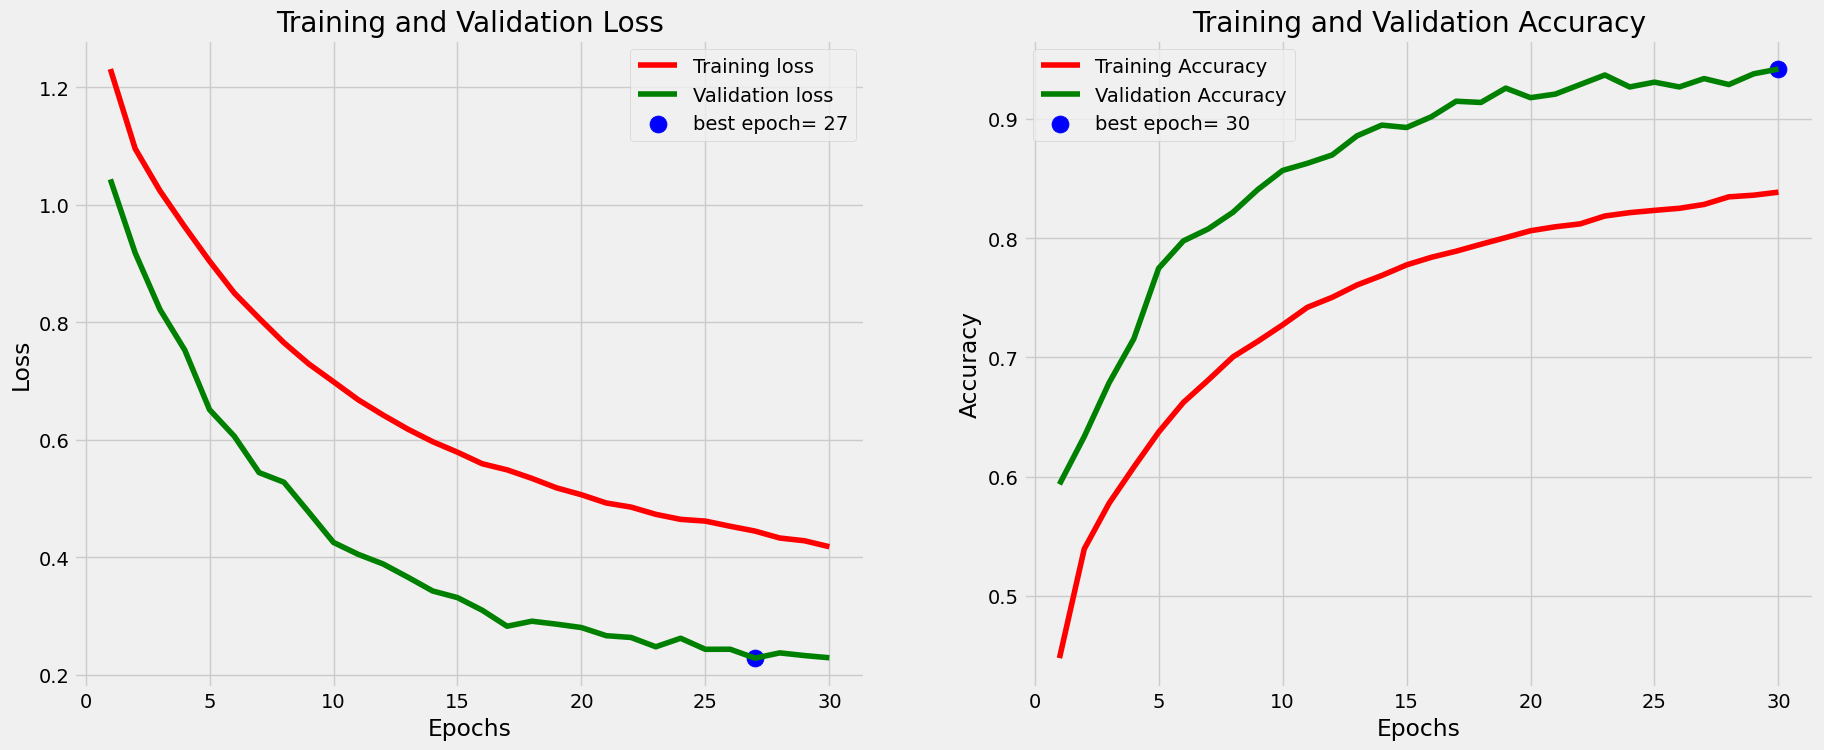

In [36]:
#Buat grafik utk keeping track
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [37]:
from sklearn.metrics import classification_report,f1_score

y_pred = custom_model.predict(X_TEST)
y_pred = np.argmax(y_pred, axis = 1)
y_true = Y_TEST
#check f1 score

calculate_f1 = classification_report(y_true, y_pred)
print(calculate_f1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       171
           1       0.94      0.95      0.95       266
           2       0.92      0.93      0.93       285
           3       0.95      0.94      0.94       277

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999



### **Sentiment Analysis Using Pre-Trained Model : Google BERT**

Sebelum menggunakan model BERT dari Google, terlebih dahulu akan diimpor modul modul yang diperlukan untuk menjalankan model ini

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

KeyboardInterrupt: 

: 

### **Inisialisasi Model**

In [26]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [31]:
#lakukan analisis sentimen dengan membuat fungsi
dictio_sentiment_score = {
    1:'Negative',
    2:'Irrelevant',
    3:'Neutral',
    4:'Positive',
    5:'Positive'
}

#definisikan fungsi
def sentiment_scoring(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+ 1

In [ ]:

df_train['sentiment_score'] = df_train['text'].apply(sentiment_scoring)
df_train

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The expanded size of the tensor (596) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [1, 596].  Tensor sizes: [1, 512]

In [ ]:
#Buat Mapping Score dari BERT menjadi skor seperti yang ada di dataset
def BERT_score_mapping(score):
    if round(score) == dictio_sentiment_score.key():
        return dictio_sentiment_score.values()

df['sentiment_score'] = df['sentiment_score'].apply(BERT_score_mapping)

### **Hitung akurasi model**

In [ ]:
#Buat fungsi metric
def classifier_metrics(sentiment_score,sentiment):
    